# Text Classification Exam

Welcome to the Text Classification Practical Exam. In this exam, you will be tasked with building, training, and evaluating an NLP model to classify text data. You are provided with a labeled dataset containing both the text and its corresponding class labels.

Your objective is to develop a model that accurately predicts the class of the given text. Make sure to follow best practices in data preprocessing, model selection, and evaluation to achieve optimal results.

Good luck!
___

# Install and Import Needed Libraries

# Download the Dataset

In [41]:
!kaggle datasets download -d khaledzsa/spam-messages
!unzip spam-messages.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/spam-messages
License(s): unknown
spam-messages.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  spam-messages.zip
replace spam.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: spam.csv                


In [42]:
import re
import pandas as pd

import pyarabic.araby as araby

import nltk
from nltk.corpus import stopwords
import nltk
from nltk.stem.isri import ISRIStemmer
nltk.download('stopwords')

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Bidirectional, SimpleRNN, LSTM

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
import spacy
from nltk.stem import PorterStemmer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Exploration

Before diving into preprocessing and model building, it’s important to first explore the dataset to understand its structure, distribution, and key characteristics. This step will help you gain insights into the data and guide your decisions in subsequent steps. Here’s what to consider:

1. **Inspect the Data**:
   Start by looking at the first few rows of the dataset to get a sense of its structure. Check the columns, data types, and a few sample entries. This helps to ensure that the data is loaded correctly and gives you an initial overview of the content.

2. **Check for Missing Values**:
   Identify if there are any missing values in the dataset.

3. **Distribution of Labels**:
   Examine the distribution of the target labels (classes).

4. **Text Data Characteristics (Bonus)**:
   Analyze the length of the text data. It is useful to calculate the number of words or characters in each text sample to understand how long the texts are. This will help you set a suitable `max_length` for tokenization and padding later. You can plot a histogram of text lengths to visualize the distribution.

5. **Common Words and Vocabulary (Bonus)**:
   Explore the most frequent words in the text data.

## Inspect the Data

In [43]:
df =pd.read_csv('/content/spam.csv')

In [44]:
df

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam
5568,Will Ì_ b going to esplanade fr home?,ham
5569,"Pity, * was in mood for that. So...any other s...",ham
5570,The guy did some bitching but I acted like i'd...,ham



## Check for Missing Values

In [45]:
 df.isnull().sum()



,0
text,0
label,0


## Distribution of Labels

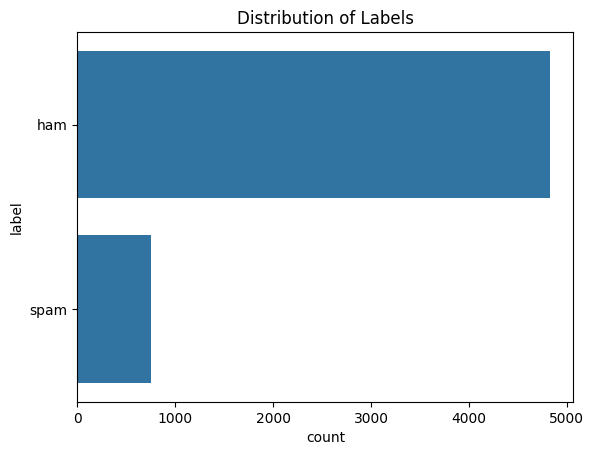

label
ham     4825
spam     747
Name: count, dtype: int64


In [46]:
sns.countplot(df['label'])
plt.title("Distribution of Labels")
plt.show()

label_counts = df['label'].value_counts()
print(label_counts)


## Text Data Characteristics (Bonus):

In [47]:
#حساب طول الكلمه
df['text_length'] = df['text'].str.split().apply(len)

In [48]:
df['text_length'].sum()

89119

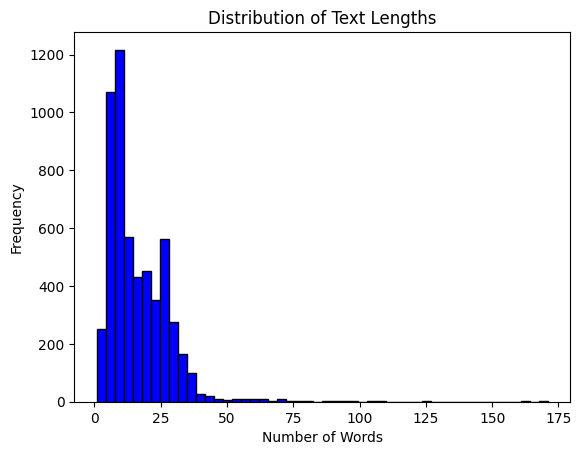

In [49]:

plt.hist(df['text_length'], bins=50, color='blue', edgecolor='black')
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


In [50]:
# Summary
df['text_length'].describe()


,text_length
count,5572.000000
mean,15.994078
std,11.332548
min,1.000000
25%,8.000000
50%,13.000000
75%,23.000000
max,171.000000


## Common Words and Vocabulary (Bonus):

In [51]:
!pip install nltk
import nltk
nltk.download('punkt')

from collections import Counter
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('.', 4843), (':', 3501), ('https', 2784), ('to', 2148), ('I', 1956), ('you', 1888), (',', 1871), ('?', 1541), ('!', 1381), ('a', 1329), ('the', 1200), ('...', 1131), ('//link1.com', 958), ('i', 944), ('&', 916), ('//link3.com', 916), ('//link2.com', 910), ('and', 865), ('in', 830), ('is', 815)]


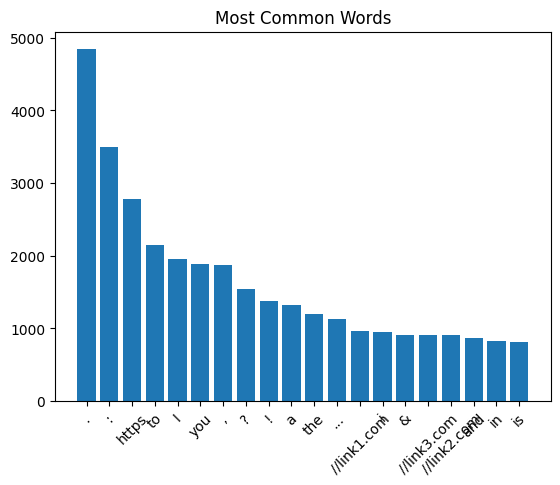

In [52]:
all_words = [word for text in df['text'] for word in word_tokenize(text)]
word_freq = Counter(all_words)

common_words = word_freq.most_common(20)
print(common_words)

words, counts = zip(*common_words)
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Most Common Words")
plt.show()


# Data Cleaning and Preprocessing

In this section, we will focus on cleaning and filtering the dataset, preparing it for the text classification task. We will implement the following steps:

1. **Remove missing values**:  
   First, we eliminate any rows with missing values to ensure the dataset is complete and consistent.

2. **Filter by text length (Bonus)**:  
   To maintain a uniform dataset, we will filter the text samples by a specified word count range. This ensures that the texts are neither too short to lack context nor too long to introduce unnecessary complexity.

3. **English stopwords loading**:  
   We load a list of English stopwords to filter out commonly used but contextually insignificant words. This is an important step for improving the performance of the model, as stopwords do not contribute valuable information.

4. **Text cleaning**:  
   We apply a series of text cleaning steps to standardize and simplify the text data. This involves:
   
   - **Removing links (URLs)**:  
     Any URLs present in the text are removed as they are not meaningful for classification purposes.
   
   - **Removing special characters and punctuation**:  
     This step removes any non-alphabetical characters, ensuring the text only contains meaningful words.
   
   - **Lowercasing**:  
     All text is converted to lowercase for uniformity and to avoid case sensitivity issues.
   
   - **Removing English stopwords**:  
     Words that are part of the stopwords list are removed, as they do not add value to the classification task.
   
   - **Stemming or Lemmatization**:  
     Either stemming or lemmatization is applied to reduce words to their root or base form, ensuring consistency in word forms.

5. **Final cleanup**:
   Apply the cleanup function to the feature column.

By following these steps, the text will be cleaned, filtered, and ready for tokenization!

## Remove missing values:

In [53]:
# no missing values

## Filter by text length (Bonus):

In [54]:

max_length = df['text'].str.len().max()


In [55]:
print(max_length)

910


## English stopwords loading:

In [34]:
#import nltk
#from nltk.corpus import stopwords

# Download the stopwords resource
#nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Text cleaning:

In [ ]:
#import re
#import nltk
#from nltk.corpus import stopwords
#from nltk.stem import PorterStemmer
#from nltk.stem import WordNetLemmatizer
#import spacy

In [56]:
# تحميل مجموعة الكلمات
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print(stop_words)

{'you', 'doesn', 'then', 'doing', 'ma', 'needn', 'them', 'it', 'have', 'but', 'any', 'other', 'above', 'than', 'who', 'him', 'herself', 'each', 'she', 'not', 'i', 'just', 've', 'weren', "you're", 'more', 'll', "didn't", 'or', 'wouldn', "hadn't", "isn't", 'whom', 'down', 'aren', 'only', 'over', "wouldn't", "she's", "won't", 'o', 'a', 'was', 'yours', "it's", 'from', 'we', 'at', 'between', 'very', 'is', "you've", "doesn't", 'had', 'below', 'were', 'during', 'once', "should've", 'mustn', "that'll", 'do', 'has', 'an', 'by', 'into', 'themselves', "couldn't", 'mightn', 'their', 'here', 'didn', "wasn't", 'should', 'd', "needn't", "haven't", 'before', "aren't", 'nor', 'be', 'yourselves', 'does', 'of', 'too', 'been', 'ours', 'the', 'don', 'to', 'further', 'so', 'out', 'because', 'about', 'in', 'all', 'such', 'won', 'after', 'hadn', 'while', 're', "mightn't", 'some', 'those', 'under', 'his', 'am', 'through', 'and', 'as', 'both', 'off', "shan't", 'your', 'if', 'how', 'm', 'own', 't', "don't", 'on'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
from nltk.stem import WordNetLemmatizer
import spacy
from nltk.stem import PorterStemmer

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# تحميل  spaCy
nlp = spacy.load('en_core_web_sm')

stemmer = PorterStemmer()

def clean_text(text, method='lemmatization'):
    # إزالة الروابط
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # إزالة الرموز الخاصة
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # تحويل النص إلى حروف صغيرة
    text = text.lower()

    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]

    if method == 'stemming':
        # التجذير (Stemming)
        tokens = [stemmer.stem(word) for word in tokens]
    elif method == 'lemmatization':
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

cleaned_text = clean_text(df['text'][2])

print(f'Before: {df["text"][2]}')
print(f'After: {cleaned_text}')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Before: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's https://link2.com
After: free entry wkly comp win fa cup final tkts st may text fa receive entry questionstd txt ratetcs apply over


## Final cleanup

In [58]:
# the clean_text function to all rows in the 'text' column
df['clean_text'] = df['text'].apply(clean_text)


In [59]:
df

,text,label,text_length,clean_text
0,"Go until jurong point, crazy.. Available only ...",ham,20,go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,ham,6,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,29,free entry wkly comp win fa cup final tkts st ...
3,U dun say so early hor... U c already then say...,ham,12,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",ham,14,nah dont think go usf life around though
...,...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam,31,nd time tried contact u u pound prize claim ea...
5568,Will Ì_ b going to esplanade fr home?,ham,8,b going esplanade fr home
5569,"Pity, * was in mood for that. So...any other s...",ham,11,pity mood soany suggestion
5570,The guy did some bitching but I acted like i'd...,ham,26,guy bitching acted like id interested buying s...


# Tokenization, Padding, and Data Splitting

In this step, we will prepare the text data for input into a model by converting the text into numerical sequences, padding them to a uniform length, and splitting the dataset into training and testing sets. Here's an overview of the steps involved:

1. **Tokenization**:
   We use a tokenizer to convert the cleaned text into numerical sequences. You can use `Tokenizer` tokenizer from `tensorflow.keras.preprocessing.text` package or any other tokenizer you like.

2. **Text to sequences**:
   After fitting the tokenizer on the cleaned text, we transform each text into a sequence of numbers, where each number corresponds to a token (word) in the text.

3. **Padding the sequences**:
   Since different texts may vary in length, we pad the sequences to ensure they all have the same length.

4. **Label encoding**:
   The labels (target values) also need to be converted into numerical form if they are not encoded.

5. **Train-test split**:
   The dataset is divided into training and testing sets. We allocate 80% of the data for training the model and reserve 20% for testing its performance.
   
   - The **training data** consists of the padded sequences used to train the model.
   - The **training labels** are the encoded labels corresponding to the training data.
   - The **testing data** is used to assess the model’s performance after training.
   - The **testing labels** are the encoded labels corresponding to the testing data.

6. **Data shape confirmation**:
   After splitting the data, we print the shape (dimensions) of both the training and testing sets to confirm that the data is properly divided and formatted.

By the end of this step, the text data will be transformed into padded numerical sequences, the labels will be encoded, and the data will be split into training and testing sets for model development and evaluation.

In [65]:
df.dropna(axis=1, inplace=True)

In [66]:
df.isna().sum()

,0
text,0
label,0
text_length,0
clean_text,0


In [67]:
df.head()

,text,label,text_length,clean_text
0,"Go until jurong point, crazy.. Available only ...",ham,20,go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,ham,6,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,29,free entry wkly comp win fa cup final tkts st ...
3,U dun say so early hor... U c already then say...,ham,12,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",ham,14,nah dont think go usf life around though


## Tokenization:

In [68]:
# Initialize the tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on the 'clean_text' column of the dataframe
tokenizer.fit_on_texts(df['clean_text'])


## Text to sequences:

In [69]:

# Convert the text to sequences of integers
sequences = tokenizer.texts_to_sequences(df['clean_text'])
## تحويل النصوص إلى تسلسلات من الأرقام

## إضافة padding للتسلسلات
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

## Label encoding


In [70]:
# 4. Label encoding
# labels = df['label'].values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['label'])

In [71]:
padded_sequences.shape

(5572, 910)

In [72]:
encoded_labels.shape

(5572,)

## Train-test split:

In [73]:
# Train-test split
train_data, test_data, train_labels, test_labels = train_test_split(
    padded_sequences,
    encoded_labels,
    test_size=0.2,        # 20% for testing
    random_state=42
)


## Data shape confirmation:

In [74]:
#  Data shape confirmation
print("Shape of train_data:", train_data.shape)
print("Shape of train_labels:", train_labels.shape)
print("Shape of test_data:", test_data.shape)
print("Shape of test_labels:", test_labels.shape)


Shape of train_data: (4457, 910)
Shape of train_labels: (4457,)
Shape of test_data: (1115, 910)
Shape of test_labels: (1115,)


# Building the Classifier

In this step, you will design and build a NLP Classifier model to classify text data. Below is a breakdown of the key components you'll implement, but it's up to you to decide how to configure them based on your understanding and experimentation:

1. **Model Type**:
   You will use a Sequential model, which allows you to stack layers in a linear sequence.

2. **Input Layer**:
   Define the shape of the input data. Consider the dimensions of your padded sequences and set the input shape accordingly.

3. **Embedding Layer**:
   The embedding layer will convert input tokens (integers) into dense vector representations. You will need to determine the size of the input dimension (based on your vocabulary) and the output dimension (embedding size).

4. **Bidirectional Simple RNN/LSTM Layers**:
   You can add one or more recurrent layers. Consider using Bidirectional layers to capture contextual information from both directions (forward and backward). You can chose SimpleRNN/GRU/LSTM to perform this step.

5. **Dense Layers**:
   Add one or more fully connected (Dense) layers to process the output from the RNN/GRU/LSTM layers.

6. **Output Layer**:
   The output layer should match the type of classification task you're working on. Consider using appropriate activation function with appropriate number of units.

7. **Model Summary**:
   After defining your model architecture, print a summary to review the number of layers, types of layers, and total parameters.

8. **Model Compilation**:
   Finally, compile the model by selecting an optimizer, a loss function, and metrics.

In [76]:
# Sequential model
model = Sequential([
    Input(shape=(max_length,)),
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length),
    Bidirectional(SimpleRNN(64, return_sequences=True)),
    Bidirectional(SimpleRNN(32)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

## Model Summary

In [77]:

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 910, 128)            │       1,000,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 910, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 64)                  │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,040,193 (3.97 MB)

 Trainable params: 1,040,193 (3.97 MB)

 Non-trainable params: 0 (0.00 B)


## Model Compilation:


In [78]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Defining Batch Size, Creating Datasets, and Training the Model

In this step, you will define the batch size, create TensorFlow Datasets for both training and testing, and train the model. The key elements to consider are outlined below, and it is up to you to choose the specific configurations based on your preferences and experimentation:

1. **Batch Size**:
   Select a batch size for training and testing. The batch size determines how many samples will be processed together in one forward and backward pass during training.

2. **Creating Datasets**:
   Use TensorFlow’s `Dataset.from_tensor_slices()` to create datasets from the training and testing data.

3. **Batching the Datasets**:
   Batch the datasets by grouping the data into batches of the specified size.

4. **Training the Model**:
   Train the model by fitting it on the training dataset for a specified number of epochs. You will also need to provide the validation data to monitor the model’s performance on unseen data during training.

5. **Tracking Training History**:
   During training, the model’s performance metrics (such as loss and accuracy) will be tracked over the epochs, and the results will be stored in the `history` object.

In [79]:
batch_size = 30
#Creating Dataset
train_dataset = tensorflow.data.Dataset.from_tensor_slices((train_data, train_labels))
test_dataset = tensorflow.data.Dataset.from_tensor_slices((test_data, test_labels))

# Batch the datasets
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

history = model.fit(train_dataset, epochs=5, validation_data=test_dataset)


Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-79-f0320bb4139c>", line 10, in <cell line: 10>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 54, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/trainer.py", line 357, in _compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/trainer.py", line 325, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/compile_utils.py", line 609, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/compile_utils.py", line 645, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/loss.py", line 43, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py", line 27, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py", line 1853, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py", line 1567, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 645, in sparse_categorical_crossentropy

Received a label value of 1 which is outside the valid range of [0, 1).  Label values: 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_17516]

# Model Evaluation

Once the model is trained, the next step is to evaluate its performance on the testing dataset.

1. **Evaluate the Model**:
   You will use the `evaluate()` method to assess the model’s performance on the test dataset.

2. **Testing Dataset**:
   Ensure that the testing dataset is properly prepared and batched, just like the training dataset.

4. **Loss Curve**:
   A loss curve plots the loss values for both the training and validation datasets over the epochs.

In [85]:
# Evaluate the Model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")



InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-85-9c3f15c74ab6>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 429, in evaluate

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 154, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 85, in test_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/trainer.py", line 357, in _compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/trainer.py", line 325, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/compile_utils.py", line 609, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/compile_utils.py", line 645, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/loss.py", line 43, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py", line 27, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py", line 1853, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py", line 1567, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 645, in sparse_categorical_crossentropy

Received a label value of 1 which is outside the valid range of [0, 1).  Label values: 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_17998]

In [86]:

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

NameError: name 'history' is not defined

In [87]:
results = model.evaluate(test_data, test_labels)
print(f"Accuracy: {results[1] * 100:.2f}%")

InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-85-9c3f15c74ab6>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 429, in evaluate

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 154, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 85, in test_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/trainer.py", line 357, in _compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/trainer.py", line 325, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/compile_utils.py", line 609, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/trainers/compile_utils.py", line 645, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/loss.py", line 43, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py", line 27, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py", line 1853, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py", line 1567, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 645, in sparse_categorical_crossentropy

Received a label value of 1 which is outside the valid range of [0, 1).  Label values: 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_17998]

# Model Inference

In this step, you will use the trained model to make predictions on new, unseen data (inference). Here’s an outline of the key points:

1. **Create Test Sample**:
   Create a string to test your modelm the goal here is to give the model Before making predictions, ensure that the new data is preprocessed in the same way as the training data. This includes tokenization, padding, and any other transformations you applied during the data preprocessing step. The data can be single text to see the result of the prediction.

2. **Model Prediction**:
   Use the `predict()` method to feed new samples into the trained model and obtain predictions. The model will output probabilities or predicted class labels based on the type of classification task (binary or multi-class).

3. **Interpreting Predictions**:
   The model will return probabilities for each class.

In [89]:
# Define a sample text for prediction
sample_text = [" يوم طويل ومتعب وبس والله"]

sample_sequence = tokenizer.texts_to_sequences([clean_text(sample_text[0])])

padded_sample_sequence = pad_sequences(sample_sequence, maxlen=max_length, padding='post')


predicted_label = model.predict(padded_sample_sequence)

print("Predicted label:", label_encoder.inverse_transform([predicted_label.argmax()]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted label: ['ham']


# Notebook Question:
- How did you handle text preprocessing? Why did you choose this approach?

- Why did you choose this model design?

- Why did you pick this number of layers or units for the model?

- Why did you select these evaluation methods?

- Does your model show signs of overfitting or underfitting? How do you know?

- What changes could you make to improve the model and fix overfitting or underfitting?

Answer Here:

## How did you handle text preprocessing? Why did you choose this approach?

owercasing: Convert all text to lowercase to ensure uniformity should be treated the same.
Tokenization: Split the text into individual tokens (words, subwords, or characters). I use different tokenizers  spaCy
Removing Punctuation: Punctuation might not add value in certain tasks like sentiment analysis, so it's often removed.
Removing Stop Words: Common words like "is", "the", etc., which do not contribute much to the meaning, are removed to reduce the dimensionality.
Lemmatization/Stemming: This step reduces words


- Why did you choose this model design?

Sequential Model: The Sequential API is a straightforward way to build models layer by layer, making it easy to understand and manage.

Input Layer: The Input(shape=(max_length,)) defines the shape of the input data, which is essential for specifying the length of the sequences you will be processing.

Embedding Layer:

Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length): This layer converts integer-encoded words into dense vectors of fixed size (128 in this case). It helps in capturing semantic meanings of words and reduces dimensionality compared to one-hot encoding.
Bidirectional RNN:

Bidirectional(SimpleRNN(64, return_sequences=True)): The bidirectional layer allows the model to learn information from both past (forward) and future (backward) contexts in the sequences